In [104]:
# Import numpy, pandas, data
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr

# ETFs with explicit Adjusted Close
px = yf.download(
    ['SPY','IEF'],
    start='2005-01-01', end='2025-01-01',
    interval='1mo',
    auto_adjust=False,   # keeps "Adj Close"
    progress=False)['Adj Close'].dropna()
px.columns = ['SPY','IEF']

# Simple returns for equity and bond
ret = (px / px.shift(1) - 1).dropna()
ret.columns = ['Equity','Bond']

# Cash: TB3MS=3M T-Bill, annualized percent
tbill = pdr.DataReader('TB3MS', 'fred', start='2005-01-01', end='2025-01-01').dropna()
cash_ret = ((tbill['TB3MS'] / 100.0) / 12.0).rename('Cash')  # monthly simple return

# Merge all returns into one
returns = ret.join(cash_ret, how='inner')

print(returns.head())

              Equity      Bond      Cash
2005-02-01 -0.016689  0.020904  0.002117
2005-03-01 -0.003730 -0.022134  0.002283
2005-04-01  0.024555 -0.014881  0.002317
2005-05-01  0.018600  0.032225  0.002367
2005-06-01  0.004865 -0.002511  0.002475


In [105]:
# Portfolio definition - edit to change weights
assert list(returns.columns) == ['Equity', 'Bond', 'Cash'] #order columns from log returns for weight attribution

# Set portfolio total weight = 1
portfolio_weights = np.array([0.60, 0.35, 0.05]) #equity, bond, cash

# Monthly average returns and cov matrix
mu = returns.mean().values           # mean vector
sigma = returns.cov().values         # cov matrix


In [106]:
# Monte Carlo with monthly rebalancing
# we assume monthly returns are iid. Normal with mean mu and covariance sigma
def simulate_paths_simple(mean_returns, cov_matrix, portfolio_weights,
                          horizon_months=120, n_paths=10_000):

    random_generator = np.random.default_rng()
    n_assets = len(portfolio_weights)

    # Simulate monthly simple returns for each asset
    asset_returns = random_generator.multivariate_normal(
        mean=mean_returns,
        cov=cov_matrix,
        size=(horizon_months, n_paths))

    # Compute monthly portfolio simple returns (with rebalancing)
    portfolio_returns = asset_returns @ portfolio_weights  # (months, n_simulations)

    # Compute cumulative wealth paths)
    portfolio_wealth = np.cumprod(1 + portfolio_returns, axis=0)

    return portfolio_wealth, portfolio_returns


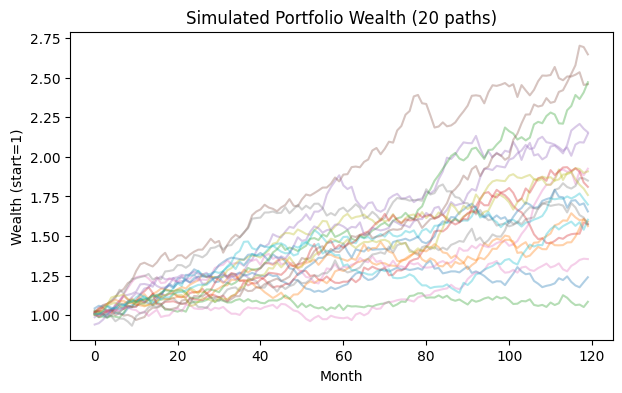

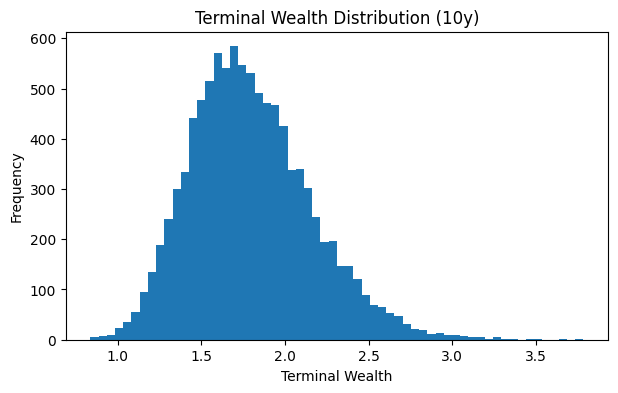

In [107]:
# Plot results
import matplotlib.pyplot as plt

portfolio_wealth, portfolio_returns = simulate_paths_simple(
    mean_returns=mu,
    cov_matrix=sigma,
    portfolio_weights=portfolio_weights)

months = portfolio_wealth.shape[0]
x = range(months)

plt.figure(figsize=(7,4))
idx = np.random.choice(portfolio_wealth.shape[1], size=20, replace=False)
plt.plot(x, portfolio_wealth[:, idx], alpha=0.35)
plt.title("Simulated Portfolio Wealth (20 paths)"); plt.xlabel("Month"); plt.ylabel("Wealth (start=1)")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(portfolio_wealth[-1, :], bins=60)
plt.title("Terminal Wealth Distribution (10y)"); plt.xlabel("Terminal Wealth"); plt.ylabel("Frequency")
plt.show()

In [108]:
# Max drawdown
peaks = np.maximum.accumulate(portfolio_wealth, axis=0)
drawdowns = 1 - portfolio_wealth / peaks
mdd_median = float(np.median(drawdowns.max(axis=0)))          # max over time, median over paths

# 1-year VaR at 5% significance level, ie, 95% VaR
alpha = 0.05
if months >= 12:
    one_year = np.prod(1 + portfolio_returns[-12:, :], axis=0) - 1  # 1y compounded return per path
    var_1y = float(np.percentile(one_year, 100 * alpha))
else:
    var_1y = float("nan")

print(f"Median Max Drawdown: {100 * mdd_median:.2f}%")
print(f"1-Year 95% VaR: {100 * var_1y:.2f}%")

Median Max Drawdown: 9.32%
1-Year 95% VaR: -4.76%
